In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define paths
base_dir =  r'C:\Users\DELL\Downloads\archive\brain_tumor_dataset'
yes_dir = os.path.join(base_dir, 'yes')
no_dir = os.path.join(base_dir, 'no')

# Lists to hold image data and labels
images = []
labels = []

# Function to load images
def load_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(150, 150))
        img = img_to_array(img)
        
        img = img / 255.0  # Normalize images
        images.append(img)
        labels.append(label)

# Load images from both folders
load_images_from_folder(yes_dir, 1)  # Label 1 for 'yes'
load_images_from_folder(no_dir, 0)   # Label 0 for 'no'

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Flip images vertically
    shear_range=0.2,     # Apply shear transformation
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)


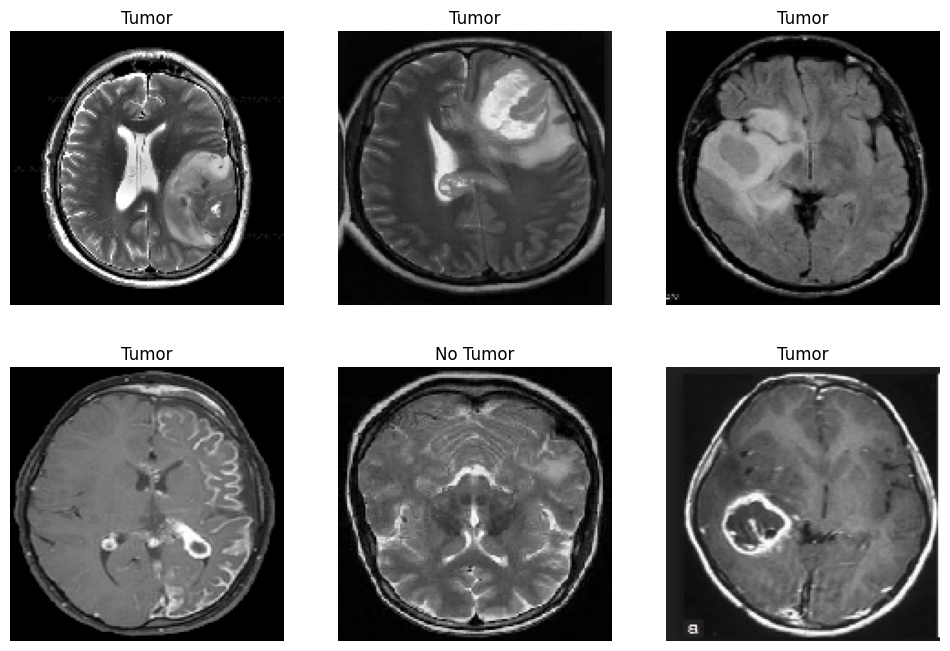

In [9]:
# Plot some sample images
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title('Tumor' if y_train[i] == 1 else 'No Tumor')
    plt.axis('off')
plt.show()


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the feature maps into a 1D vector
    Flatten(),

    # First dense layer
    Dense(256, activation='relu'),
    Dropout(0.5),

    # Second dense layer
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Third dense layer
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=15, validation_data=(X_test, y_test))


In [19]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.regularizers import l2
import numpy as np
from tensorflow.keras.applications import VGG16

# Load VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
l=len(base_model.layers)-2
# Freeze the convolutional base
base_model.trainable = True
for layers in base_model.layers[:l] :
    layers.trainable=False  

# Add custom layers on top of it
model = Sequential([
    base_model,
    GlobalAveragePooling2D(), #
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# Early Stopping and Model Checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=8, validation_data=(X_test, y_test))
fine_tune_history = model.fit(
     train_generator,
    epochs=8,
     validation_data=(X_test, y_test),
     callbacks=[early_stopping, model_checkpoint ]
 )
base_model.summary()

Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 854ms/step - accuracy: 0.6236 - loss: 0.7706 - val_accuracy: 0.6667 - val_loss: 0.5198
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 704ms/step - accuracy: 0.7174 - loss: 0.7540 - val_accuracy: 0.7843 - val_loss: 0.4888
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 688ms/step - accuracy: 0.7345 - loss: 0.5192 - val_accuracy: 0.7059 - val_loss: 0.5155
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 685ms/step - accuracy: 0.7848 - loss: 0.4777 - val_accuracy: 0.8039 - val_loss: 0.4379
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 698ms/step - accuracy: 0.7923 - loss: 0.4086 - val_accuracy: 0.8235 - val_loss: 0.4758
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 701ms/step - accuracy: 0.8868 - loss: 0.3354 - val_accuracy: 0.7843 - val_loss: 0.4118
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 705ms/step - accuracy: 0.8959 - loss: 0.2928 - val_accuracy: 0.8431 - val_loss: 0.4760
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 719ms/step - accuracy: 0.8672 - loss: 0.2766 - val_accuracy: 0.7647 - val_loss: 0.5248


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 2,359,808 (9.00 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [20]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 753ms/step - accuracy: 0.8329 - loss: 0.4120
Test Accuracy: 0.8431


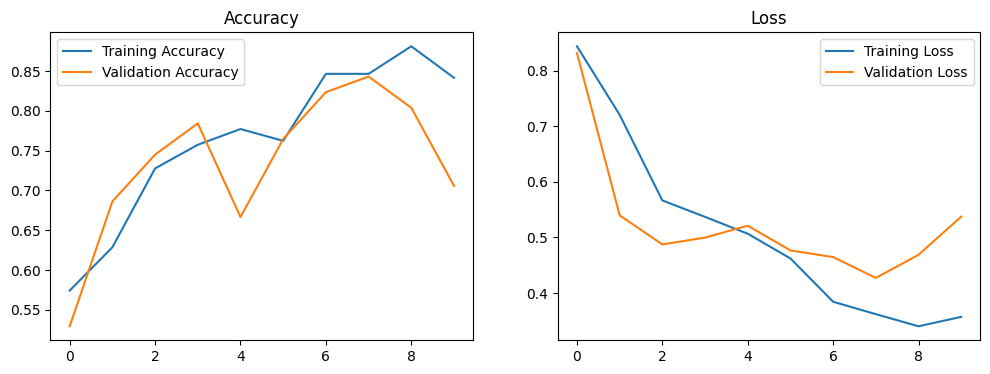

In [11]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [12]:
model.save('brain_tumor_detection_model.h5')
